<a href="https://www.kaggle.com/code/evelynartoria/digit-recognizer-tinyvgg-pytorch?scriptVersionId=186893143" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Import needed libraries

In [2]:
import torch
from torch import nn

In [3]:
import matplotlib.pyplot as plt
import os
import shutil

In [4]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"torch default device set to {device}")

torch default device set to cpu


In [6]:
train_csv = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_csv = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train_csv

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Prepare the dataset

In [7]:
def make_dataset(csv, train: bool):
    images = []
    labels = []
    for row in range(len(csv)):
        if train:
            pixels = csv.iloc[row, 1:].values
            label = csv.iloc[row, 0]           
            labels.append(label)
        else:
            pixels = csv.iloc[row].values
            
        image = pixels.reshape(1, 28, 28)
        images.append(image)
        
    images_tensor = torch.tensor(images, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    print(images_tensor.shape)
    print(labels_tensor.shape)
    
    if train == False:
        labels_tensor = torch.zeros(size=[len(csv)]) # create a dummy target tensor, since the train csv does not have any targets
    dataset = TensorDataset(images_tensor, labels_tensor)
    return dataset
        
        

In [8]:
train_dataset = make_dataset(csv=train_csv, train=True)
test_dataset = make_dataset(csv=test_csv, train=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return func(*args, **kwargs)


torch.Size([42000, 1, 28, 28])
torch.Size([42000])
torch.Size([28000, 1, 28, 28])
torch.Size([0])


# Visualize random data

In [9]:
def show_image(tensor):
    # permute 1, 2, 0 is needed so color channels are the dimension (matplotlib.pyplot.imshow expects the C as the last dimension)
    plt.imshow(tensor.permute(1, 2, 0), cmap="gray")
    
def show_random_image(dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    show_image(dataset[x][0])
    print(f"target is {dataset[x][1]}")

target is 0


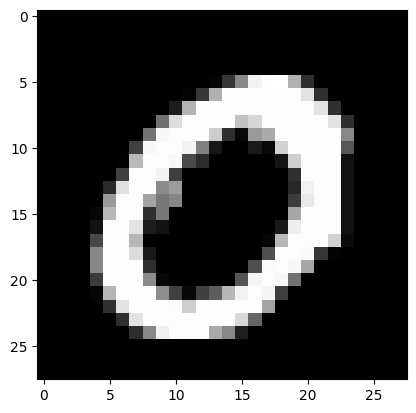

In [10]:
show_random_image(dataset=train_dataset)

# Make dataloaders for batched training

In [11]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, generator=torch.Generator(device=device))

In [12]:
test_batch_images, test_batch_labels = next(iter(train_dataloader))

print(test_batch_images.shape)
print(test_batch_labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


# Construct the TinyVGG model using pytorch

In [13]:
class TinyVGG(nn.Module):
    def __init__(self, input_size, hidden_units, n_classes):
        super().__init__()
        
        self.n_max_pools = 2
        
        self.conv2d_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv2d_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(hidden_units*(28/(self.n_max_pools**2))*(28/self.n_max_pools**2)), out_features=n_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv2d_block_1(x)
        x = self.conv2d_block_2(x)
        x = self.classifier(x)
        return x

# Define the model, optimizer and loss function

In [14]:
model = TinyVGG(input_size=1, hidden_units=5, n_classes=10)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

# Define the train loop

In [15]:
def train_model(model, train_dataloader, loss_fn, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        for batch, (images, labels) in enumerate(train_dataloader):
            logits = model(images)
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if batch % 300 == 0:
                print(f"loss at batch {batch} --> {loss} at epoch {epoch}")
                
    print(f"loss of the very last batch --> {loss}")
        

In [16]:
train_model(model=model, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=50)

loss at batch 0 --> 2.3657400608062744 at epoch 0
loss at batch 300 --> 0.16981321573257446 at epoch 0
loss at batch 600 --> 0.0432780385017395 at epoch 0
loss at batch 0 --> 0.21010324358940125 at epoch 1
loss at batch 300 --> 0.08835504949092865 at epoch 1
loss at batch 600 --> 0.050036147236824036 at epoch 1
loss at batch 0 --> 0.1892475187778473 at epoch 2
loss at batch 300 --> 0.03945082426071167 at epoch 2
loss at batch 600 --> 0.040292900055646896 at epoch 2
loss at batch 0 --> 0.2185382843017578 at epoch 3
loss at batch 300 --> 0.15721569955348969 at epoch 3
loss at batch 600 --> 0.09661415964365005 at epoch 3
loss at batch 0 --> 0.09659509360790253 at epoch 4
loss at batch 300 --> 0.05323989316821098 at epoch 4
loss at batch 600 --> 0.012524032965302467 at epoch 4
loss at batch 0 --> 0.1000133603811264 at epoch 5
loss at batch 300 --> 0.15287652611732483 at epoch 5
loss at batch 600 --> 0.11900009959936142 at epoch 5
loss at batch 0 --> 0.0994315817952156 at epoch 6
loss at ba

In [17]:
def random_predictions(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image = dataset[x][0]
    show_image(image)
    
    with torch.inference_mode():
        logits = model(image.unsqueeze(dim=0)) # data must be batched
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        print(f"model prediction --> {pred.item()}")

model prediction --> 7


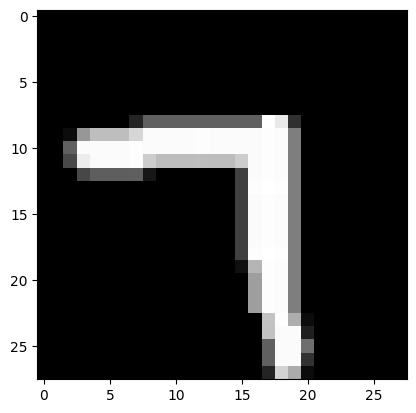

In [18]:
random_predictions(model=model, dataset=train_dataset)

# Make predictions on test.csv and save a submission.csv file

In [19]:
print(test_dataset[:][0].shape)

torch.Size([28000, 1, 28, 28])


In [20]:
with torch.inference_mode():
    image_ids = [idx+1 for idx in range(len(test_csv))]
    
    logits = model(test_dataset[:][0])
    preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    preds = preds.cpu().detach().numpy()
    
    df = pd.DataFrame(
        {
            "ImageId": image_ids,
            "Label": preds
        }
    )
    
    #os.remove("/kaggle/working/test.csv")
    df.to_csv("/kaggle/working/test.csv", index=False)
    
    

In [21]:
#os.remove("/kaggle/working/test.csv")
#os.remove("./submission.csv")

In [22]:
shutil.copy("/kaggle/working/test.csv", "./submission.csv")

'./submission.csv'